<a href="https://colab.research.google.com/github/arnabGudu/IBMHackathon/blob/master/seq2seq_multistep_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone https://github.com/gautham20/pytorch-ts.git
# !mv pytorch-ts pytorch_ts
# !pip install torch-lr-finder
# !pip install torchcontrib

from google.colab import drive
drive.mount('/content/drive')

!cp drive/My\ Drive/datasets/wind_dataset/T1.csv wind.csv

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
# import plotly_express as px
import matplotlib.pyplot as plt

# Data Preprocessing

## Feature Engineering

In [ ]:
original_data = pd.read_csv('wind.csv')
data = original_data.copy()

data.rename(columns={"Date/Time":"Time",
                     "LV ActivePower (kW)":"Active_Power(kW)",
                     "Wind Speed (m/s)":"WindSpeed(m/s)",
                     "Wind Direction (°)":"Wind_Direction"},
            inplace=True)
data.head()

,Time,Active_Power(kW),WindSpeed(m/s),Theoretical_Power_Curve (KWh),Wind_Direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [ ]:
# All Transform funtions

def find_month(x):
  months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
            'Oct', 'Nov', 'Dec']
  for i in range(12):
    if " 0" + str(i + 1) + " " in x:
      return months[i]

def mean_speed(x):
  return [i - 0.25 for i in np.arange(0.25, 25.5 + 0.5, 0.5) if x < i][0]

def mean_direction(x):
  x = [i - 15 for i in np.arange(15, 375 + 30, 30) if x < i][0]
  return 0 if x == 360 else x

def find_direction(x):
  months = ['N', 'NNE', 'NEE', 'E', 'SEE', 'SSE', 
            'S', 'SSW', 'SWW', 'W', 'NWW', 'NNW']
  for i in range(12):
    if i * 30 == x:
      return months[i]

In [ ]:
data['Month'] = data.Time.apply(find_month)
data['mean_WindSpeed'] = data['WindSpeed(m/s)'].apply(mean_speed)
data['mean_Direction'] = data['Wind_Direction'].apply(mean_direction)
data['Direction'] = data['mean_Direction'].apply(find_direction)
data.head()

,Time,Active_Power(kW),WindSpeed(m/s),Theoretical_Power_Curve (KWh),Wind_Direction,Month,mean_WindSpeed,mean_Direction,Direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904,Jan,5.5,270,W
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113,Jan,5.5,270,W
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789,Jan,5.0,270,W
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087,Jan,5.5,270,W
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286,Jan,5.5,270,W


In [ ]:
len(data['WindSpeed(m/s)'])

# Remove the data that wind speed is smaller than 3.5 and bigger than 25.5
data = data[(data['WindSpeed(m/s)'] >  3.5) & 
            (data['WindSpeed(m/s)'] <= 25.5)]

# Number of values where wind speed is bigger than 3.5 and active power is zero.
data = data[((data['Active_Power(kW)'] != 0) & 
             (data['WindSpeed(m/s)'] > 3.5)) | 
            data['WindSpeed(m/s)'] <= 3.5]

len(data['WindSpeed(m/s)'])

40635

In [ ]:
# Loss calculation
data = data.sort_values('Time')
data['Loss_Value(kW)'] = data['Theoretical_Power_Curve (KWh)'] - data['Active_Power(kW)']
data['Loss(%)'] = data['Loss_Value(kW)']/data['Theoretical_Power_Curve (KWh)']*100

r = {i:2 for i in list(data.keys())}
data = data.round(r)
data.head()

,Time,Active_Power(kW),WindSpeed(m/s),Theoretical_Power_Curve (KWh),Wind_Direction,Month,mean_WindSpeed,mean_Direction,Direction,Loss_Value(kW),Loss(%)
0,01 01 2018 00:00,380.05,5.31,416.33,259.99,Jan,5.5,270,W,36.28,8.71
1,01 01 2018 00:10,453.77,5.67,519.92,268.64,Jan,5.5,270,W,66.15,12.72
2,01 01 2018 00:20,306.38,5.22,390.90,272.56,Jan,5.0,270,W,84.52,21.62
3,01 01 2018 00:30,419.65,5.66,516.13,271.26,Jan,5.5,270,W,96.48,18.69
4,01 01 2018 00:40,380.65,5.58,491.70,265.67,Jan,5.5,270,W,111.05,22.59


In [ ]:
def summary(input):
  data_ = data.groupby(input).mean()
  data_.drop(columns={"WindSpeed(m/s)", "Wind_Direction", "mean_Direction"},
                  inplace=True)
  
  data_[input] = data_.index.copy()
  # data_ = data_[["WindSpeed(m/s)","ActivePower(kW)","Theoretical_Power_Curve (KWh)",
  #                "Loss_Value(kW)","Loss(%)"]]

  # data_["Index"] = list(range(1, len(data_.index) + 1))
  # data_.setIndex("Index", inplace=True)

  # data_ = data_.round({"WindSpeed(m/s)": 1, 'ActivePower(kW)': 2, 
  #                      'Theoretical_Power_Curve (KWh)': 2, 
  #                      'Loss_Value(kW)': 2, 'Loss(%)': 2})
  
  # data_["count"] = [len(data['mean_WindSpeed'][data['mean_WindSpeed'] == i])
  #                   for i in data_['WindSpeed(m/s)']]
  return data_

In [ ]:
summary('mean_WindSpeed').head()

,Active_Power(kW),Theoretical_Power_Curve (KWh),Loss_Value(kW),Loss(%),mean_WindSpeed
mean_WindSpeed,,,,,
3.5,35.813634,67.725698,31.911848,47.427813,3.5
4.0,86.081407,127.311024,41.229642,32.821543,4.0
4.5,167.611158,221.949533,54.338354,24.776826,4.5
5.0,269.380503,336.488211,67.107954,20.013567,5.0
5.5,385.072374,472.130461,87.058216,18.487364,5.5


# Data Processing

In [ ]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'])
# print start datetime and end datetime
print(data['Date/Time'].min(), data['Date/Time'].max())

# TODO
# set test data to nan
# 

data['Wind Direction (°)'].describe()

data['dayofweek'] = data['Date/Time'].dt.dayofweek
data['month'] = data['Date/Time'].dt.month
data['day'] = data['Date/Time'].dt.day

2018-01-01 00:00:00 2018-12-31 23:50:00


In [ ]:
def sin_transform(values):
    return np.sin(2*np.pi*values/len(set(values)))

def cos_transform(values):
    return np.cos(2*np.pi*values/len(set(values)))

In [ ]:
data['dayofweek_sin'] = sin_transform(data['dayofweek'])
data['dayofweek_cos'] = cos_transform(data['dayofweek'])
data['month_sin'] = sin_transform(data['month'])
data['month_cos'] = cos_transform(data['month'])
data['day_sin'] = sin_transform(data['day'])
data['day_cos'] = cos_transform(data['day'])

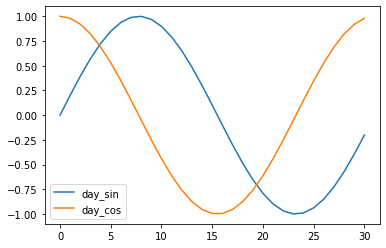

In [ ]:
# data = data.sort_values(['store_item_id', 'date'])

plt.plot(sin_transform(np.arange(0,31)), label='day_sin')
plt.plot(cos_transform(np.arange(0,31)), label='day_cos')
plt.legend()

# Prepare Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class WindDataset(Dataset):
  def __init__(self, cat_columns=[], num_columns=[], embed_vector_size=None, 
               decoder_input=True, ohe_cat_columns=False):
    super().__init__()
    self.sequence_data = None
    self.cat_columns = cat_columns
    self.num_columns = num_columns
    self.cat_classes = {}
    self.cat_embed_shape = []
    self.cat_embed_vector_size = embed_vector_size if embed_vector_size is not None else {}

    self.pass_decider

In [ ]:
train_dataset = WindDataset(cat_columns=['store', 'item'], num_columns=['yearly_corr'],
                            embed_vector_size={'store': 4, 'item': 4},
                            ohe_cat_columns=True)
valid_dataset = WindDataset(cat_columns=['store', 'item'], num_columns=['yearly_corr'],
                            embed_vector_size={'store': 4, 'item': 4},
                            ohe_cat_columns=True)
test_dataset = WindDataset(cat_columns=['store', 'item'], num_columns=['yearly_corr'],
                            embed_vector_size={'store': 4, 'item': 4},
                            ohe_cat_columns=True)

In [ ]:
train_dataset.load_sequence_data(train_sequence_data)
valid_dataset.load_sequence_data(valid_sequence_data)
test_dataset.load_sequence_data(test_sequence_data)

# Encoder Decoder Model

In [ ]:
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim

from pytorch_ts.ts_models.encoders import RNNEncoder, RNNConcatEncoder, RNNInitEncoder
from pytorch_ts.ts_models.decoders import DecoderCell, AttentionDecoderCell
from pytorch_ts.ts_models.encoder_decoder import EncoderDecoderWrapper
# from pytorch_ts.ts_models.encoder_decoder_attention import EncoderDecoderAttentionWrapper

from pytorch_ts.torch_utils.cocob import COCOBBackprop
from pytorch_ts.torch_utils.trainer import TorchTrainer
import torchcontrib

torch.manual_seed(420)
np.random.seed(420)

In [ ]:
device = 'cpu'

encoder = RNNEncoder(
    input_feature_len = 71,
    rnn_num_layers = 1,
    hidden_size = 100,
    sequence_len = 180,
    bidirectional = False,
    device = device,
    rnn_dropout = 0.2
)

decoder_cell = DecoderCell(
    input_feature_len = 10,
    hidden_size = 100,
)

loss_function = nn.MSELoss()

encoder = encoder.to(device)
decoder_cell = decoder_cell.to(device)

model = EncoderDecoderWrapper(
    encoder,
    decoder_cell,
    output_size = 90,
    teacher_forcing = 0,
    sequence_len = 180,
    decoder_input = True,
    device=device,
)

model = model.to(device)

encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = 1e-3, 
                                      weight_decay = 1e-2)
decoder_optimizer = torch.optim.AdamW(decoder_cell.parameters(), lr = 1e-3, 
                                      weight_decay = 1e-2)

encoder_scheduler = optim.lr_scheduler.OneCycleLR(encoder_optimizer, 
                                                  max_lr=1e-3, 
                                                  steps_per_epoch=len(train_dataloader), 
                                                  epochs=6)
decoder_scheduler = optim.lr_scheduler.OneCycleLR(decoder_optimizer, 
                                                  max_lr=1e-3, 
                                                  steps_per_epoch=len(train_dataloader), 
                                                  epochs=6)

model_optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


NameError: ignored

In [ ]:
trainer = TorchTrainer(
    model,
    [encoder_optimizer, decoder_optimizer],
    loss_function,
    [encoder_scheduler, decoder_scheduler],
    device,
    scheduler_batch_step=True,
    pass_y = True,
)

# Prediction

In [ ]:
import datetime
import time

data = pd.read_csv('wind.csv')
data.rename(columns={'Theoretical_Power_Curve (KWh)':'Power',
                     'LV ActivePower (kW)':'ActivePower',
                     "Wind Speed (m/s)":"WindSpeed",
                     "Wind Direction (°)":"WindDirection"},
            inplace=True)
data['Time']=data['Date/Time'].apply(lambda x: time.strptime(x,"%d %m %Y %H:%M")[4])
data.head()

In [ ]:
temp = data['Time'][1:].values - data['Time'][0:-1].values
temp = np.array([0] + list(temp))
data['TimeDiff'] = temp
data.TimeDiff.unique()

data['Gust'] = np.array([0] + list(data['WindSpeed'][1:].values - 
                                   data['WindSpeed'][:-1].values))

data = data[data['TimeDiff'].isin([10, -50])]
data = data[data['ActivePower'] >= 0]
data.head()

,Date/Time,ActivePower,WindSpeed,Power,WindDirection,Time,TimeDiff,Gust
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286,40,10,-0.081733
5,01 01 2018 00:50,402.391998,5.604052,499.436385,264.578613,50,10,0.026111
6,01 01 2018 01:00,447.605713,5.793008,557.372363,266.163605,0,-50,0.188956
7,01 01 2018 01:10,387.242188,5.306050,414.898179,257.949493,10,10,-0.486958
8,01 01 2018 01:20,463.651215,5.584629,493.677652,253.480698,20,10,0.278579


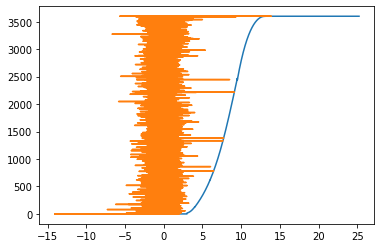

In [ ]:
x = data.sort_values(by='WindSpeed')['WindSpeed']
y = data.sort_values(by='WindSpeed')['Power']
z = data.sort_values(by='WindSpeed')['Gust']

plt.plot(x,y)
plt.plot(z,y)

In [ ]:
x_train = data[['WindSpeed', 'WindDirection', 'Gust']].values
y_train = data['ActivePower'].values